In [1]:
from datetime import datetime, date, timedelta
from dateutil.parser import parse
import math
import os
import sys
import time

import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

import mapclassify as mc

from pathlib import Path
import requests,json

In [2]:
def read_json_ESRI():
    #
    # Connect to RKI ESRI data service to get the Landkreis geodata
    # and the population data of the Landkreise
    # 
    # Input : None
    # Output: result: GeoDataFrame of the RKI Landkreise
    #
    url="https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/RKI_Landkreisdaten/FeatureServer/0/query?"

    parameter = {
        'referer':'https://www.mywebapp.com',
        'user-agent':'python-requests/2.9.1',
        'where': '1=1', # Welche landkreise sollen zurück gegeben werden
        'outFields': 'RS,GEN,county,EWZ,BL_ID,BL,EWZ_BL', # Rückgabe aller Felder
        'returnGeometry': True, # Mit Geometrien
        'f':'geojson', # Rückgabeformat, hier JSON
        'cacheHint': True # Zugriff über CDN anfragen
    }
    
    result = requests.get(url=url, params=parameter) #Anfrage absetzen
    resultjson = json.loads(result.text) # Das Ergebnis JSON als Python Dictionary laden
    result=gpd.GeoDataFrame.from_features(resultjson)
    result.set_crs(epsg=4326, inplace=True)
    return result



def read_json_BL():
    #
    # Connect to RKI ESRI data service to get the Bundeslaender geodata
    # 
    # Input : None
    # Output: result: GeoDataFrame of the RKI Bundeslaender
    #
    
    url="https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/Coronaf%C3%A4lle_in_den_Bundesl%C3%A4ndern/FeatureServer/0/query?"
    
    parameter = {
        'referer':'https://www.mywebapp.com',
        'user-agent':'python-requests/2.9.1',
        'where': '1=1', # Welche landkreise sollen zurück gegeben werden
        'outFields': 'LAN_ew_GEN,LAN_ew_BEZ', # Rückgabe aller Felder
        'returnGeometry': True, # Mit Geometrien
        'f':'geojson', # Rückgabeformat, hier JSON
        'cacheHint': True # Zugriff über CDN anfragen
    }
    result = requests.get(url=url, params=parameter) #Anfrage absetzen
    resultjson = json.loads(result.text) # Das Ergebnis JSON als Python Dictionary laden
    result=gpd.GeoDataFrame.from_features(resultjson)
    result.set_crs(epsg=4326, inplace=True)
    return result



def get_covid_data_from_RKI(outfile):
    #
    # Connect to RKI data service to download the latest covid database (full version)
    # 
    # Input : outfile, name of csv-file which has the complete covid data 
    # Output: filesize of the csv-file
    #
    covid_url = \
'https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data' 
    r = requests.get(covid_url, allow_redirects=True)
    filesize = open(covid_path, 'wb').write(r.content)
    return(filesize)



def read_covid_database(covid_file):
    #
    # Wrapper function for downloading and reading the covid database
    # 
    # Input : covid-file, name of csv-file which has the complete covid data 
    # Output: covid, the complete covid dataframe
    #
    # Remark: Since downloading takes some time, it ist tested if an actual 
    # version of the csv-file already exists on disc
    #
    covid_path=Path(covid_file)
    if not covid_path.is_file():
        get_covid_data_from_RKI(covid_file)
    else:
        print('Using already existing file ', covid_file)
    covid = pd.read_csv(covid_file, parse_dates=['Meldedatum'])
    return(covid)



def get_bundeslad_geodata(bula_file):
    #
    # Read Bundesland geodaten
    #
    # Input: bula_file, Datenfile
    # Output: bland, GeoDataFrame of Bundeslaender
    #
    bula_path=Path(bula_file)
    if not bula_path.is_file():
        bland = read_json_BL()
        bland.to_file(bula_file)
    else:
        bland = gpd.read_file(bula_file)
    return bland



def get_kreise_geodata(kreise_file):
    #
    # Read Landkreis geodaten
    #
    # Input: kreise_file, Datenfile
    # Output: kreise, GeoDataFrame of Landkreise
    #
    kreise_path=Path(kreise_file)
    if not kreise_path.is_file():
        kreise = read_json_ESRI()
        kreise.to_file(kreise_file)
    else:
        kreise = gpd.read_file(kreise_file)
    return(kreise)



def extract_einwohnerzahlen(kreise):
    #
    # Returns table of populations from Landkreise, 
    # Bundesländer und Germany
    # 
    # Input : kreise, ESRI Landkreis Geodataframe
    # Output: einwohner, Datafram with all the population 
    # data (Landkreise, bundeslaendern, germany) 
    
    ewz=pd.DataFrame(kreise)

    bl=ewz.groupby('BL').EWZ_BL.max()
    lk=ewz.groupby('county').EWZ.max()

    summe_ew_deutschland = bl.sum()
    
    einwohner=pd.concat([lk,bl])
    einwohner.loc['Deutschland']=summe_ew_deutschland

    return(einwohner)



def get_tagesinzidenzen(covid, start_date, end_date):
    # 
    # This s one of the main routines:
    # Generate a datelist for every day of the pandemic and 
    # use this list as an index to create an empty dataframe
    #
    # Input: covid, Covid dataframe from RKI
    # Input: start, end: Starting and end-date for the resulting dataframe
    # Output: result, the complete Inzidenz table for all Kreise,
    #         Bundeslaender and Germany for every day from start to end
    #
    tagesliste = pd.date_range(start_date,end_date)
    result=pd.DataFrame(index=tagesliste)
    
    # Main grouping steps for Landkreise, Bundesländer und Deutschland gesamt
    Faelle_lk = covid.groupby(['Landkreis', 'Meldedatum']).AnzahlFall.sum()
    Faelle_bl = covid.groupby(['Bundesland', 'Meldedatum']).AnzahlFall.sum()
    Faelle_d  = covid.groupby('Meldedatum').AnzahlFall.sum()

    lk_auswahl=landkreise
    for i in lk_auswahl:
        tmp=Faelle_lk[i]
        result = pd.concat([result, tmp.rename(i)], axis=1)

    bl_auswahl=bundeslaender
    for i in bl_auswahl:
        tmp=Faelle_bl[i]
        result = pd.concat([result, tmp.rename(i)], axis=1)
    
    result = pd.concat([result,Faelle_d.rename('Deutschland')], axis=1)
    
    return(result)



def didt_hist(data, 
              x='Prozentuale Änderung der 7 Tage Inzidenz/100T EW',
              y='Antzahl Land-/Stadtkreise',
              t='Anz. Landkreise über Inzidenzändeung in %',
              ref='gegenüber vor x Tagen',
              bins=list(range(-100,110,10)),
              file='Histogram'
             ):
    #
    # Histogramm Wrapper to show a histogramm for 
    # number of landkreise with a specific change in Inzidenz
    #
    fig, ax = plt.subplots(1,1,figsize=(8,6),dpi=75)
    data.hist(ax=ax, bins=bins)
              
    ax.set_ylabel(y)
    ax.set_xlabel(x)
    ax.set_title(t)
    ax.set_xlim(bins[0],bins[-1])
    ax.text(0.01,0.02,copyright2, rotation=90, transform=ax.transAxes)

    neg=len(data[data<0])
    pos=len(data[data>=0])
    mean=data.mean()
           
    Summary7 = 'Stand '+ ende.strftime('%d.%m.%Y') \
+ '\n' + str(neg) + ' Landkreise fallend ' \
+ '\n' + str(pos) + ' Landkreise steigend ' \
+ '\nMittlere Änderung ' + '{:.2f}'.format(mean) + '%'

    at = AnchoredText(
        Summary7, prop=dict(size=11), frameon=True, loc='upper right')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

    histplotfile7=ende.strftime('%y%m%d') + '_' + file + '.png'
    fig.savefig(histplotfile7, dpi=100)
    return(len(data))


def print_tabular_overview(tdata, title='Kreise Top 5 Änderungen'):
    fig, ax = plt.subplots(1,1, figsize=(10,2), dpi=300)
    #
    # Table Wrapper to show a table
    # of landkreise with a specific change in Inzidenz
    #
    top=tdata.reset_index()
    top=top.round(2)

    table = ax.table(cellText=top.values, 
                     colLabels=["Kreis","Inzidenz","Änd. Vortag [%]", 
                                "Änd. Vorwoche [%]", "Fälle"], loc='center')
    table.scale(1,1.2)

    ax.set_title(title, fontsize=12)
    ax.axis('off')
    
    return()


def inzidenz_lineplot(overview,topscorer,filename='Inzidenzen'):
    #
    # Linplot wrapper to show a lineplot
    # of several landkreise
    # Input: overview: Landkreise/Bundeslaender plotted with thick lines
    # input: topscorer: Landkreise/Bundeslaender plotted with thin lines
    #
    fig, ax = plt.subplots(1,1, figsize=(12.,6))
    
    ax.grid()
    ax.set_title('7 Tage Neuinfektionen / 100.000 EW',fontsize=16)
    ax.set_xlabel('Datum', fontsize=12)
    ax.set_ylabel('Inzidenz', fontsize=12)


    for i in overview:
        if i == 'Deutschland':
            lw=3
        else:
            lw = 2
        ax.plot(result_s7[i], label=i, linewidth=lw)
    
    for i in topscorer:
        lw = 1
        ax.plot(result_s7[i], label=i, linewidth=lw)
    
    ax.set_xlim([datetime(2021,10,15),datetime(2022,1,15)])
    ax.set_yscale('log')

    ax.set_ylim([10,1000])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.legend(loc='best', fontsize=12)
    ax.text(0.02,.96,copyright2, transform=ax.transAxes)

    txt='Stand '+ ende.strftime('%d.%m.%Y')
    ax.text(.8,.96,txt, transform=ax.transAxes)

    inzplotfile=ende.strftime('%y%m%d') + '_' + filename + '.png'
    fig.savefig(inzplotfile, dpi=100)
    return(inzplotfile)


    
def geoplot(data, color='INZ', cmap='GnBu', bins=[5, 20, 35, 50, 100, 200, 300, 1000],
            title='Inzidenzkarte_Deutschland',
            filename='Inzidenzkarte_Deutschland'):
    #
    # Mainplot mit Bundeslandgrenzen
    #
    # input: Geodataframe of Landkreise with additional columns containing
    #        Inzidenz Numbers od Delta-Inzidenz Numbers
    #
    title   = title + ' am ' + ende.strftime('%d.%m.%Y')

    fig, ax = plt.subplots(1,1, figsize=(10,12), dpi=100)

    #ax = tmpkreise.plot(figsize=(15,15), edgecolor='grey', column='INZ', cmap='tab10', scheme='MaximumBreaks', legend=True)
    #ax = tmpkreise.plot(figsize=(15,15), edgecolor='grey', column='INZ', cmap='tab10', scheme='Quantiles', legend=True)

    data.plot(ax=ax, edgecolor='grey', column=color, cmap=cmap, 
              scheme='UserDefined', classification_kwds={'bins': bins},
              legend=True, legend_kwds={'loc': 'upper left', 'fontsize': '8'})

    ax2=bland.plot(ax=ax, edgecolor='white', color='none')

    ax.axis('off')
    ax.set_title(title)
    ax.text(5.5,47,copyright2)

    pre_str=ende.strftime('%Y%m%d')
    diagram_file=pre_str + "_" + filename + '.png'

    plt.savefig(diagram_file, dpi=300)
    return(diagram_file)

In [3]:
#
# Some constants and names
#
CM = 1/2.54 # cm vs. inch

DEBUG = True

#Do not forget to reference the data source:
copyright2 = "Datenquellenvermerk: Robert Koch-Institut (RKI), dl-de/by-2-0"
overview = ['Deutschland', 'Bayern', 'SK München']
today = datetime.today().strftime('%y%m%d')


#Filenames for external Data files
covid_file  = "data/" + today + "_RKI_COVID19.csv"
bula_file   = 'landkreise/bundeslaender.shp'
kreise_file = 'landkreise/landkreise.shp'


# Data is stored in subdirectories 'data' and 'landkreise'
data_paths = ['data', 'landkreise']
for i in data_paths:
    if not os.path.exists(i):
        os.makedirs(i)

In [4]:
# Load the covid database via pd.read_csv()

covid  = read_covid_database(covid_file)
bland  = get_bundeslad_geodata(bula_file)
kreise = get_kreise_geodata(kreise_file)
einwohner = extract_einwohnerzahlen(kreise)

start=covid['Meldedatum'].min()
ende=covid['Meldedatum'].max()

landkreise=covid['Landkreis'].unique()
bundeslaender=covid['Bundesland'].unique()

result = get_tagesinzidenzen(covid, start, ende)

if DEBUG:
    print('Start Erfassung:', start.strftime('%d.%m.%Y')) 
    print('Ende  Erfassung:', ende.strftime('%d.%m.%Y'))
    print('Anzahl Bundesländer:', len(bundeslaender))
    print('Anzahl Landkreise:', len(landkreise))
    print('Einwohner Deutschland:', einwohner['Deutschland'])

Using already existing file  data/220105_RKI_COVID19.csv
Start Erfassung: 02.01.2020
Ende  Erfassung: 04.01.2022
Anzahl Bundesländer: 16
Anzahl Landkreise: 411
Einwohner Deutschland: 83155031


In [5]:
# Now we do some calculations with our daily incidence dataframe

# Calculate Rolling 7 day average and 7 day accumulation    
    
result.fillna(value=0, inplace=True)
result_m7 = result.rolling(7).mean()
result_s7 = result.rolling(7).sum()

# Calculate 7 day Inzidenz per 100.000 inhabitants:

for i in result_s7.columns:
    result_s7[i] = result_s7[i]*100000/ float(einwohner.loc[i])

# Zeitliche Änderung der Inzidenzen berechnen:

dinz_dt = pd.DataFrame(
    {'INZ': result_s7.iloc[-1], 
     'DINZ1': (result_s7.iloc[-1] - result_s7.iloc[-2])/result_s7.iloc[-2]*100,
     'DINZ7': (result_s7.iloc[-1] - result_s7.iloc[-8])/result_s7.iloc[-8]*100, 
    'MELD': result.iloc[-1]}
)

top3=dinz_dt.sort_values(by='DINZ7').iloc[-3:]
top5=dinz_dt.sort_values(by='DINZ7').iloc[-5:]

inztop5=dinz_dt.sort_values(by='INZ').iloc[-5:]
        
# County Bezeichnungen, Inzidenzen und Delta-Inzidenzen zum gpd File dazumergen

tmpkreise = kreise.copy()
tmpdinzdt=dinz_dt.reset_index()

tmpdinzdt.rename(columns={'index':'county'}, inplace=True)
tmpkreise=pd.merge(tmpkreise, tmpdinzdt, on='county', how='left')

In [6]:
if DEBUG:
    print('Überblick')
    print('Inzidenz','\t','Neue Fälle','\t','Kreis')
    for i in overview:
        print(round(result_s7.iloc[-1][i],1), 
              '\t\t', result.iloc[-1][i].astype(int),'\t\t',i)
    print('\nTop Änderungen')
    print('Inzidenz','\t','Neue Fälle','\t','Kreis')
    for i in list(top3.index):
        print(round(result_s7.iloc[-1][i],1), 
              '\t\t', result.iloc[-1][i].astype(int),'\t\t',i)
        
    print('\nTop Inzidenzen')
    print('Inzidenz','\t','Neue Fälle','\t','Kreis')
    for i in list(inztop5.index):
        print(round(result_s7.iloc[-1][i],1), 
              '\t\t', result.iloc[-1][i].astype(int),'\t\t',i)


Überblick
Inzidenz 	 Neue Fälle 	 Kreis
258.2 		 44803 		 Deutschland
212.9 		 6290 		 Bayern
238.1 		 670 		 SK München

Top Änderungen
Inzidenz 	 Neue Fälle 	 Kreis
434.9 		 165 		 LK Nordfriesland
477.7 		 127 		 LK Sankt Wendel
495.3 		 124 		 LK Rendsburg-Eckernförde

Top Inzidenzen
Inzidenz 	 Neue Fälle 	 Kreis
564.4 		 173 		 SK Erfurt
575.2 		 725 		 Bremen
580.9 		 70 		 LK Hildburghausen
620.4 		 565 		 SK Bremen
656.7 		 113 		 LK Dithmarschen


()

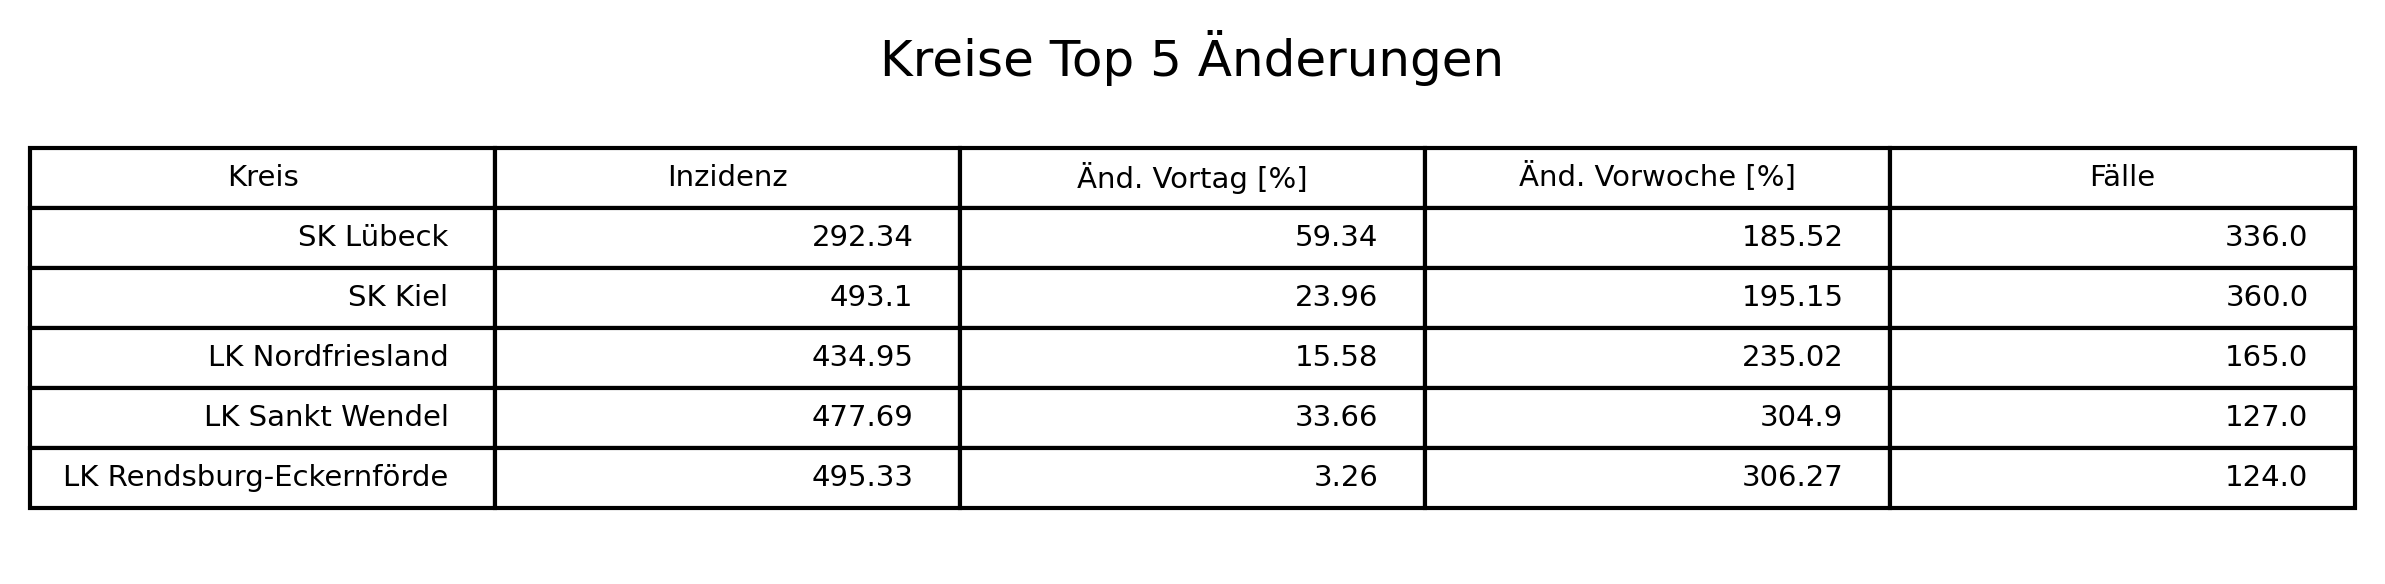

In [7]:
# Print table with the top 5 Landkreise with the highest change in Inzidenz
top5_inzidenzaenderungen = dinz_dt.sort_values(by='DINZ7').iloc[-5:]
print_tabular_overview(top5_inzidenzaenderungen)

'220104_inzplot_top5.png'

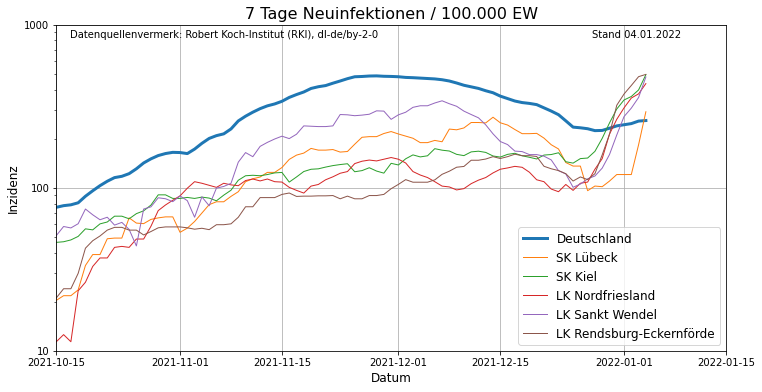

In [8]:
# Plot the top 5 Landkreise with the highest change in Inzidenz
# compared to Germany as reference
#
ref=['Deutschland']
top5_delta_inz = top5.index
inzidenz_lineplot(ref,top5_delta_inz,filename='inzplot_top5')

'220104_inzplot_Bayern.png'

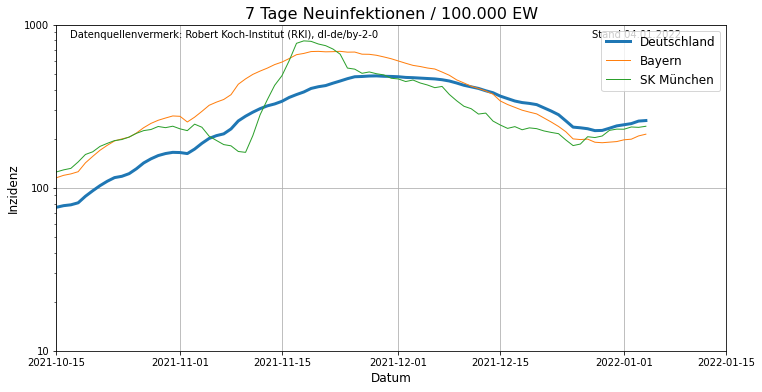

In [9]:
# Just plot some Landkreise or bundeslaender 
# compared to Germany as reference
#
ref=['Deutschland']
sample = ['Bayern', 'SK München']
inzidenz_lineplot(ref,sample,filename='inzplot_Bayern')

'20220104_Inzidenzkarte.png'

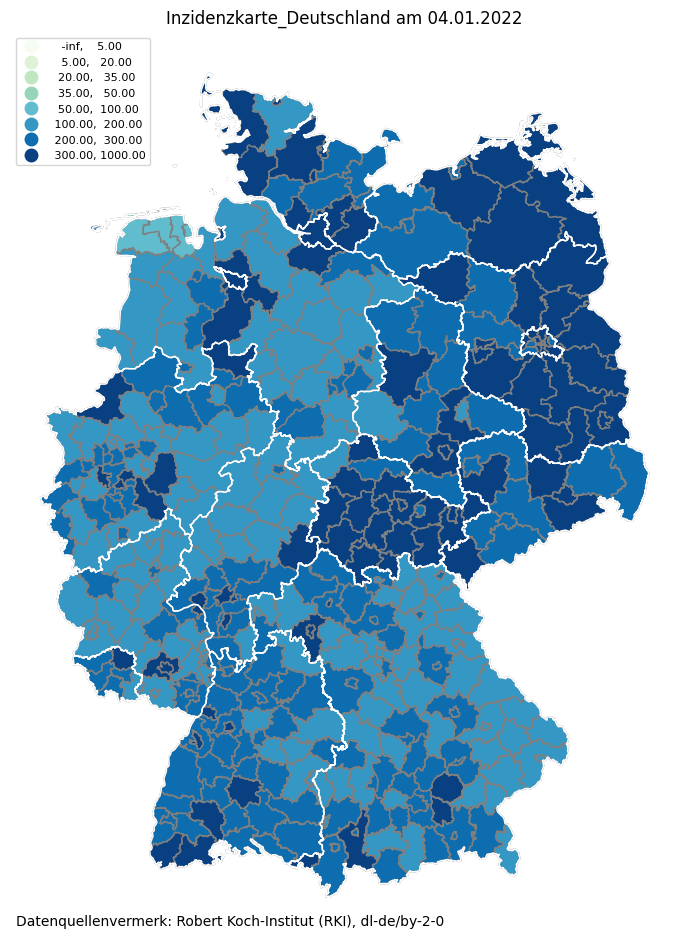

In [10]:
# Geoplot of all Landkreise and Inzidenz of last available day
geoplot(tmpkreise, color='INZ', cmap='GnBu', 
        bins=[5, 20, 35, 50, 100, 200, 300, 1000],
        filename='Inzidenzkarte')

'20220104_Delta-Inzidenz.png'

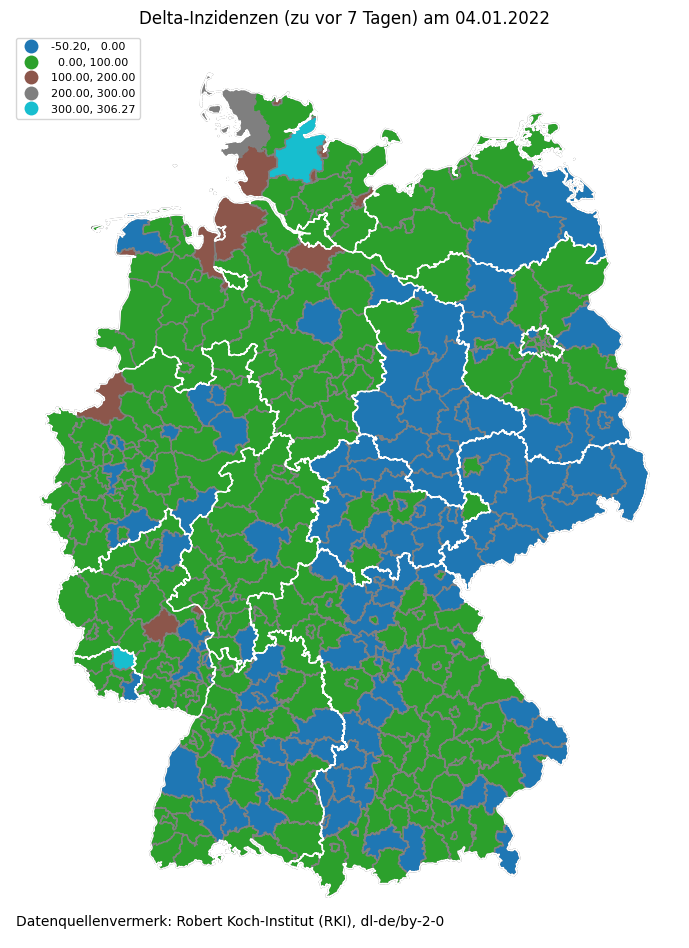

In [11]:
# Geoplot of all Landkreise showing the change of Inzidenz compared to 7 days before
geoplot(tmpkreise, color='DINZ7', 
        cmap='tab10', bins=[0, 100, 200, 300], 
        title='Delta-Inzidenzen (zu vor 7 Tagen)',
        filename='Delta-Inzidenz')

411

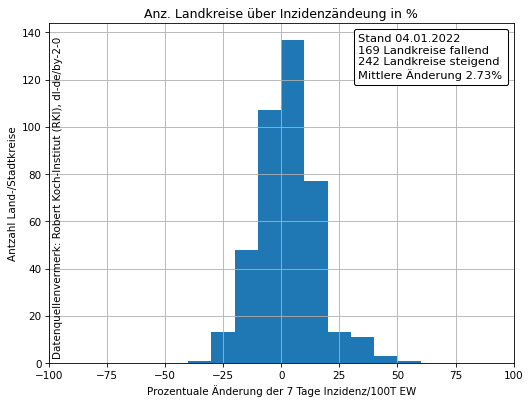

In [12]:
# Histogram showing number of landkreise over Inzidenz change compared to day before last
# available data
didt_hist(dinz_dt.DINZ1.iloc[0:411],ref=' ggüb. vor einem Tag', file='Histogramm1')

411

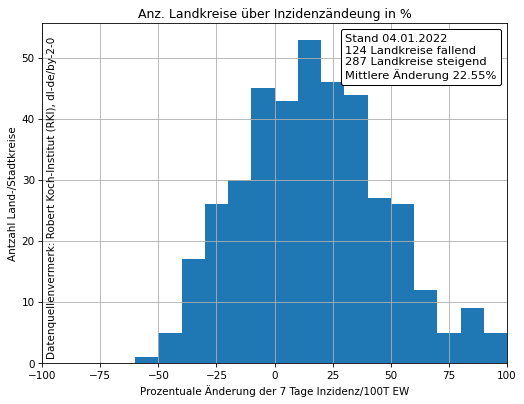

In [13]:
# Histogram showing number of landkreise over Inzidenz change compared to week before
#
didt_hist(dinz_dt.DINZ7.iloc[0:411],ref=' ggüb. vor einer Woche', file='Histogramm7')

In [14]:
# find landkreise with zero cases (or no report)
xyz=result.iloc[-1]
xy=xyz.value_counts()
xy=xy.sort_index()
print(xy[0.0], 'Kreise mit 0 Meldungen')

4 Kreise mit 0 Meldungen


In [ ]:
### Debug and test section

In [ ]:
#
# Just some lines to test and look into variables
#